# Part 2: Modeling & Evaluation

## Imports

In [1]:
# Standard Imports
import warnings
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt

# Modeling & Preprocessing Imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import MinMaxScaler
from sklearn.decomposition   import PCA
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from xgboost                 import XGBClassifier

# Custom Modules & Visualizations
import graphs
from model_evaluation        import confusion_matrix_dataframe, classification_summary
from sklearn.tree            import export_graphviz

# Appearance
from IPython.core.display    import display, HTML

# Notebook Preferences
display(HTML("<style>.container { width:95% !important; }</style>"))
warnings.filterwarnings("ignore")
%matplotlib inline

## Table Of Contents

- [Data Overview](#Data-Overview)
    - [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    
- [Preprocessing](#Preprocessing)
    - [Train-Test Split](#Train-Test-Split)
    - [Principal Component Analysis](#Principal-Component-Analysis)
    
- [Modeling](#Modeling)
    - [_k_-Neighbors Classifier](#_k_-Neighbors-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [SGD Logistic Regressor](#SGD-Logistic-Regression)
    - [XGBoost Classifier](#XGBoost-Classifier)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    
- [Evaluation](#Evaluation)
    - [Predictions Dataframe](#Predictions-Dataframe)

## Data Overview

### Reading In The Daa

In [2]:
phys_data = pd.read_csv("../Data/clean_phys_data.csv")

### Overview

In [3]:
# Head five rows

phys_data.head()

,id,life_time,dira,flight_distance,flight_distance_error,ip,ip_sig,vertex_chi2,pt,doca1,...,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,spdhits,signal
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,0
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,0
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,0
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,0
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,0


In [4]:
# Shape of the data

print(f"The dataframe has {phys_data.shape[0]} rows and {phys_data.shape[1]} rows.")

The dataframe has 67553 rows and 48 rows.


In [5]:
# Data types

phys_data.dtypes

id                         int64
life_time                float64
dira                     float64
flight_distance          float64
flight_distance_error    float64
ip                       float64
ip_sig                   float64
vertex_chi2              float64
pt                       float64
doca1                    float64
doca2                    float64
doca3                    float64
ip_p0p2                  float64
ip_p1p2                  float64
isolationa                 int64
isolationb                 int64
isolationc                 int64
isolationd               float64
isolatione               float64
isolationf               float64
iso                      float64
cdf1                     float64
cdf2                     float64
cdf3                     float64
iso_sum_bdt              float64
p0_iso_bdt               float64
p1_iso_bdt               float64
p2_iso_bdt               float64
p0_track_chi2_dof        float64
p1_track_chi2_dof        float64
p2_track_c

In [6]:
# Missing Values

phys_data.isnull().sum().sum()

0

## Preprocessing

### Train-Test Split

In [7]:
# Setting up our X and y variables

X = phys_data.drop(["id", "signal"], axis = 1)
y = phys_data["signal"]

In [8]:
# Instantiating the train-test split
# Stratifying on the `y` allows us to
# maintain the ration of the target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

Because our data has 48 columns, we are concerned that there will be significant variance in our models' performance.  To combat that, we will be making use of principal component analysis (PCA) to reduce the dimensionality of our data.

In [9]:
# MinMax scaling the data for the PCA

# Instantiating the scaler
mm_scaler  = MinMaxScaler()

# Scaling the training data
X_train_mm = mm_scaler.fit_transform(X_train)

# Scaling the test data
X_test_mm  = mm_scaler.fit_transform(X_test)

### Principal Component Analysis

PCA is a dimensionality reduction techinique that reduces the dimensionality of large data sets by transforming them into smaller ones. This method works by scaling the data (generally by subtracting the mean and then dividing by the standard deviation. Covariance matrices are created, transformed into eigenvectors from which eigenvalues are extracted. The principal components are then ranked by their eigenvalues. Then eigenvectors are created out of the principal components which then have the original values recast onto them.

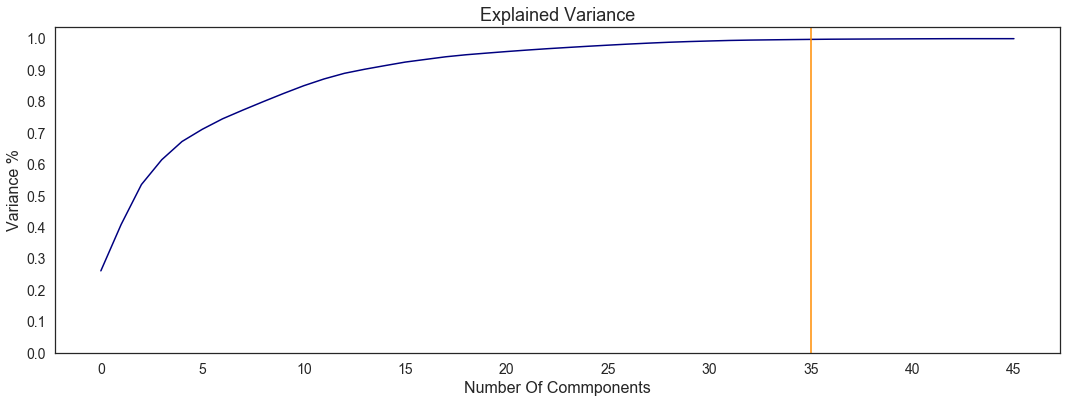

Based on the image above, we concluded that our ideal number of components is 35.

In [10]:
# Instantiating PCA
pca = PCA(n_components = 35,
          random_state = 42,
          whiten       = True)

# Fit-transforming the training data
X_train_pca = pca.fit_transform(X_train_mm)

# Fit-transforming the test data
X_test_pca  = pca.fit_transform(X_test_mm)

## Modeling

**Process**:

The data will be classified using three different types of algorithms: distance based, decision trees, and logistic regression. Each individual model (four in total) will be gridsearched to ensure that our hyperparameters have optimal values; hyperparameters are parameters that the user must set.  After each model is fit to the data and has made predictions, they will be evaluated in two ways: a confusion matrix and a standardized set of metrics.

Additionally, each model will be run on the original data and the data that has been through PCA.

**Evaluation**:

Our evaluation process has three steps: confusion matrices, metrics, and an ROC curve.

The confusion matrix will show us what kind of predictions are made, i.e. false positives and negatives.  Each confusion matrix will contain:
 
|                   | Pred. Neg.      | Pred. Pos.      |
|:------------------|:---------------:|:---------------:|
| **Actual Neg.** | True Negatives  | False Positives |
| **Actual Pos.** | False Negatives | True Positives  |

The metrics all us to evaluate the models in different ways.  Each model will be evaluated with the following:

| Metric                                     | Description                                                                       | Scale    |
|:-------------------------------------------|:----------------------------------------------------------------------------------|:--------:|
| **Recall**                                 | How many positive classes were classified correctly out of all positives          | 0 to 1   |
| **Specificity**                            | How many negative classes were classified correctly out of all negatives          | 0 to 1   |
| **AUROC**                                  | A measure of the model's ability to distinguish classes                           | 0.5 to 1 |
| **Matthews Correlation Coefficient (MCC)** | A measure of classification quality: correlation between true and prediced values | -1 to 1  |

Finally, once we have chosen a best model we will generate a ROC curve for that model.

### _k_-Neighbors Classifier

_k_-Neighbors classification is a non-parametric algorithm, i.e. it does not make any assumptions about the data.  It works based off of distance: it chooses _k_ points and classifies by choosing the majority.

#### Original Data

In [ ]:
"""
# Instantiating the grid search's pipeline
knn_pipe  = Pipeline([("knn", KNeighborsClassifier(n_jobs = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(knn__n_neighbors  = [7],
                 knn__weights      = ["uniform"],
                 knn__algorithm    = ["auto"])

# Setting up the gridsearch object
knn_gs    = GridSearchCV(knn_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
knn_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
knn_gs.best_params_
""";

In [11]:
# Instantiating the KNN classifier

knn = KNeighborsClassifier(n_neighbors = 7)

In [12]:
# Fitting the algorithm to our training data
knn.fit(X_train, y_train)

# Making training predictions
train_preds = knn.predict(X_train)

# Making test predictions
knn_preds   = knn.predict(X_test)

In [13]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.853271
Specificity,0.477459
MCC,0.360724
AUROC,0.665365


In [14]:
# Evaluating prediction on the test data

classification_summary(y_test, knn_preds)

,Scores
Sensitivity,0.775506
Specificity,0.333539
MCC,0.119934
AUROC,0.554523


In [15]:
# Creating a confusion matrix from the test predictions

confusion_matrix_dataframe(y_test, 
                           knn_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,2158,4312
Actual μμμ,2339,8080


#### Principal Component Analysis

In [ ]:
"""
# Instantiating the grid search's pipeline
knn_pipe  = Pipeline([("knn", KNeighborsClassifier(n_jobs = 6))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(knn__n_neighbors  = [7],
                 knn__weights      = ["uniform"],
                 knn__algorithm    = ["auto"])

# Setting up the gridsearch object
knn_gs    = GridSearchCV(knn_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
knn_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
knn_gs.best_params_
""";

In [21]:
# Instantiating the k neighbors algorithm
# The other parameters are their default values

knn2 = KNeighborsClassifier(n_neighbors = 7)

In [22]:
# Fitting the algorithm to our training data
knn2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = knn2.predict(X_train_pca)

# Making test predictions
knn2_preds   = knn2.predict(X_test_pca)

In [23]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.969989
Specificity,0.647689
MCC,0.679052
AUROC,0.808839


In [24]:
# Evaluating prediction on the test data

classification_summary(y_test, knn2_preds)

,Scores
Sensitivity,0.918802
Specificity,0.318083
MCC,0.305193
AUROC,0.618443


In [25]:
# Creating a confusion matrix from the test predictions

confusion_matrix_dataframe(y_test, 
                           knn2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,2058,4412
Actual μμμ,846,9573


### Random Forest Classifier

A random forest classifier is a tree-based classification method that incorporates two types of random selection: bootstrapping (random sampling of the data with replacement) and random selection of features.

#### Original Data

In [35]:
# Instantiating the grid search's pipeline
rfr_pipe  = Pipeline([("rfr", RandomForestClassifier(random_state = 42,
                                                     n_jobs       = 4))])

# Setting up a hyperparameter dictionary
params    = dict(rfr__n_estimators = [600],
                 rfr__max_depth    = [13,15,17])

# Setting up the gridsearch object
rfr_gs    = GridSearchCV(rfr_pipe, 
                         param_grid = params,
                         cv         = 5)
                          
# Fitting the gridsearch to our training data
rfr_gs.fit(X_train, y_train);

# Printing out our best parameters
rfr_gs.best_params_

{'rfr__max_depth': 17, 'rfr__n_estimators': 600}

In [ ]:
# Instantiating the random forest classifier
# Other parameters are at their defaults

rfr = RandomForestClassifier(random_state      = 42,
                             n_jobs            = 4,
                             n_estimators      = 175,
                             max_depth         = 25,
                             min_samples_split = 3,
                             min_samples_leaf  = 1)

In [ ]:
# Fitting the algorithm to our training data
rfr.fit(X_train_pca, y_train)

# Making training predictions
train_preds = rfr.predict(X_train_pca)

# Making test predictions
rfr_preds   = rfr.predict(X_test_pca)

In [ ]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

In [ ]:
# Evaluating prediction on the test data

classification_summary(y_test, rfr_preds)

In [ ]:
confusion_matrix_dataframe(y_test, 
                           rfr_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

In [ ]:
rfr_original_data = pd.DataFrame(rfr.feature_importances_,
                                 columns = ["RF - Original Data"])

rfr_original_data.sort_values(by = "RF - Original Data", ascending = False).head()

### Principal Component Analysis

In [ ]:
"""
# Instantiating the grid search's pipeline
rfr2_pipe  = Pipeline([("rfr2", RandomForestClassifier(random_state = 42,
                                                     n_jobs       = 4))])

# Setting up a hyperparameter dictionary
params    = dict(rfr2__n_estimators      = [193],
                 rfr2__max_depth         = [22],
                 rfr2__min_samples_split = [3],
                 rfr2__min_samples_leaf  = [3])

# Setting up the gridsearch object
rfr2_gs    = GridSearchCV(rfr2_pipe, 
                         param_grid = params,
                         cv         = 5)
                          
# Fitting the gridsearch to our training data
rfr2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
rfr2_gs.best_params_
""";

In [ ]:
# Instantiating the random forest classifier
# Other parameters are at their defaults

rfr2 = RandomForestClassifier(random_state      = 42,
                              n_jobs            = 4,
                              n_estimators      = 193,
                              max_depth         = 22,
                              min_samples_split = 3,
                              min_samples_leaf  = 3)

In [ ]:
# Fitting the algorithm to our training data
rfr2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = rfr2.predict(X_train_pca)

# Making test predictions
rfr2_preds   = rfr2.predict(X_test_pca)

In [ ]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

In [ ]:
# Evaluating prediction on the test data

classification_summary(y_test, rfr2_preds)

In [ ]:
confusion_matrix_dataframe(y_test, 
                           rfr2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

In [ ]:
rfr2_original_data = pd.DataFrame(rfr2.feature_importances_,
                                 columns = ["RF - PCA"])

rfr2_original_data.sort_values(by = "RF - PCA", ascending = False).head()

### SGD Logistic Regressor

The version of the logistic regression incorporates the use of stochastic gradient descent (SGD). Gradient descent is a way of minimizing a model's loss function (in this case cross-entropy) by taking "steps" to find the lowest (global) minimum. SGD is one of three main ways this is performed. As stochastic suggests, SGD logistic regression suggests a few points randomly from our data for each iteration of the mode and after each iteration the data is shuffled and resampled.

#### Original Data

In [ ]:
"""
# Instantiating the grid search's pipeline
sgd_pipe = Pipeline([("sgd", SGDClassifier(random_state = 42,
                                           n_jobs       = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(sgd__loss           = ["log"],
                 sgd__early_stopping = [False],
                 sgd__penalty        = ["l2"],
                 sgd__alpha          = [0.001],
                 sgd__max_iter       = [5],
                 sgd__tol            = [0.01])

# Setting up the gridsearch object
sgd_gs   = GridSearchCV(sgd_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to our training data
sgd_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
sgd_gs.best_params_
""";

In [ ]:
# Instantiating the sgd logistic regression classifier
# Other parameters are at their defaults

sgd = SGDClassifier(random_state   = 42,
                    n_jobs         = 4,
                    loss           = "log",
                    early_stopping = False,
                    penalty        = "l2",
                    alpha          = 0.001,
                    max_iter       = 5,
                    tol            = 0.01)

In [ ]:
# Fitting the algorithm to our training data
sgd.fit(X_train_pca, y_train)

# Making training predictions
train_preds = sgd.predict(X_train_pca)

# Making test predictions
sgd_preds   = sgd.predict(X_test_pca)

In [ ]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

In [ ]:
# Evaluating prediction on the test data

classification_summary(y_test, sgd_preds)

In [ ]:
confusion_matrix_dataframe(y_test, 
                           sgd_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

In [ ]:
sgd_coefs = pd.DataFrame([np.exp(i) for i in sgd.coef_], index = ["Coef."]).T
sgd_coefs.sort_values(by = "Coef.", ascending = False).head()

#### Principal Component Analysis

In [ ]:
"""
# Instantiating the grid search's pipeline
sgd2_pipe = Pipeline([("sgd", SGDClassifier(random_state = 42,
                                           n_jobs       = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(sgd2__loss           = ["log"],
                 sgd2__early_stopping = [False],
                 sgd2__penalty        = ["l2"],
                 sgd2__alpha          = [0.001],
                 sgd2__max_iter       = [5],
                 sgd2__tol            = [0.01])

# Setting up the gridsearch object
sgd2_gs   = GridSearchCV(sgd_pipe2, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
sgd2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
sgd2_gs.best_params_
""";

In [ ]:
# Instantiating the SGD classifier

sgd2 = SGDClassifier(random_state   = 42,
                     n_jobs         = 4,
                     loss           = "log",
                     early_stopping = False,
                     penalty        = "l2",
                     alpha          = 0.001,
                     max_iter       = 5,
                     tol            = 0.01)

In [ ]:
# Fitting the algorithm to our training data
sgd2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = sgd2.predict(X_train_pca)

# Making test predictions
sgd2_preds   = sgd2.predict(X_test_pca)

In [ ]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

In [ ]:
# Evaluating prediction on the test data

classification_summary(y_test, sgd2_preds)

In [ ]:
confusion_matrix_dataframe(y_test, 
                           sgd2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

In [ ]:
sgd2_coefs = pd.DataFrame([np.exp(i) for i in sgd2.coef_], index = ["Coef."]).T
sgd2_coefs.sort_values(by = "Coef.", ascending = False).head()

### XGBoost Classifier

#### Original Data

In [ ]:
#Instantiating the grid search's pipeline
xgb_pipe = Pipeline([("xgb", XGBClassifier(random_state = 42,
                                           n_jobs       = 4,
                                           verbosity    = 0))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(xgb__max_depth    = [7],
                 xgb__n_estimators = [100,150,200])

# Setting up the gridsearch object
xgb_gs   = GridSearchCV(xgb_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to our training data
xgb_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
xgb_gs.best_params_

In [ ]:
xgb = XGBClassifier()

#### Principal Component Analysis 

In [ ]:
"""
Instantiating the grid search's pipeline
xgb_pipe = Pipeline([("xgb2", XGBClassifier(random_state = 42,
                                           n_jobs       = 4,
                                           verbosity    = 0))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(xgb2__max_depth     = [8],
                 xgb2__n_estimators  = [350],
                 xgb2__learning_rate = [0.1],
                 xgb2__booster       = ["gbtree"],
                 xgb2__gamma         = [0])

# Setting up the gridsearch object
xgb2_gs   = GridSearchCV(xgb2_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
xgb2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
xgb2_gs.best_params_
""";

In [ ]:
# Instantiating the XGBoost classifier
# Other hyperparameters are defaults

xgb2 = XGBClassifier(random_state = 42,
                     n_jobs       = 4,
                     verbosity    = 0,
                     max_depth    = 8,
                     n_estimators = 350)

In [ ]:
# Fitting the algorithm to our training data
xgb2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = xgb2.predict(X_train_pca)

# Making test predictions
xgb2_preds   = xgb2.predict(X_test_pca)

In [ ]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

In [ ]:
# Evaluating prediction on the test data

classification_summary(y_test, xgb2_preds)

In [ ]:
confusion_matrix_dataframe(y_test, 
                           xgb2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

## Evaluation

### Predictions Dataframe

#### Original Data

In [20]:
original_data_predictions = pd.DataFrame([np.array(y_test), knn_preds], index = ["True Value","KNN"]).T
original_data_predictions.head()

,True Value,KNN
0,1,1
1,1,1
2,0,1
3,1,0
4,1,0


#### Principal Component Analysis

In [26]:
pca_data_predictions = pd.DataFrame([np.array(y_test), knn2_preds], index = ["True Value","KNN"]).T
pca_data_predictions.head()

,True Value,KNN
0,1,1
1,1,1
2,0,1
3,1,1
4,1,1
